In [1]:
# New einsum approach
# Message passing may be possible only in C

# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

466
156
{'meta': {'AgeInMonths': 146, 'Gender': 'F', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 2, 'AgeGroupEdge1': 144, 'AgeGroupEdge2': 180}, 'rest': '30', 'nback': '31', 'emoid': '31', 'ID': 600262185931}


In [2]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['rest']), '../../rest_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [102]:
print(train_rest_ts[0].shape)

(264, 124)


In [107]:
train_rest_ts_torch = [torch.from_numpy(sub.T).float() for sub in train_rest_ts]
test_rest_ts_torch = [torch.from_numpy(sub.T).float() for sub in test_rest_ts]

print('Complete')

Complete


In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Nroi = train_rest_ts_torch[0].shape[1]
Nhid = 100
Nlat = 80

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.fc1 = nn.Linear(Nroi, Nhid)
        self.fc2 = nn.Linear(Nhid, Nlat)
        self.fc3 = nn.Linear(Nlat, Nhid)
        self.fc4 = nn.Linear(Nhid, Nroi)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        y = self.fc2(x)
        x = F.relu(self.fc3(y))
        x = self.fc4(x)
        return x, y
    
ae = AE()
optim_ae = torch.optim.Adam(ae.parameters(), lr=1e-3)

print('Complete')

Complete


In [121]:
# Dimension reduction

Nbatch = 10
N = len(train_rest_ts_torch)
running = 0
Nepoch = 2000
pPeriod = 100

for epoch in range(Nepoch):
    batch = []
    for i in range(Nbatch):
        idx = random.randint(0,N-1)
        batch.append(train_rest_ts_torch[idx])
    batch = torch.cat(batch)
    optim_ae.zero_grad()
    recon, lat = ae(batch)
    loss = torch.sum((batch-recon)**2)
    running += loss.detach()
    loss.backward()
    optim_ae.step()
    if epoch % pPeriod == 0 or epoch == Nepoch-1:
        if epoch != 0:
            if epoch % pPeriod != 0:
                running /= epoch % pPeriod
            else:
                running /= pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, running))
        running = 0

print('Finished training')

epoch 0 loss=329822.937500
epoch 100 loss=216980.359375
epoch 200 loss=159549.343750
epoch 300 loss=141044.718750
epoch 400 loss=130755.750000
epoch 500 loss=122933.843750
epoch 600 loss=119001.843750
epoch 700 loss=112930.062500
epoch 800 loss=109134.679688
epoch 900 loss=104922.000000
epoch 1000 loss=102102.539062
epoch 1100 loss=100296.210938
epoch 1200 loss=99491.828125
epoch 1300 loss=97897.570312
epoch 1400 loss=97888.601562
epoch 1500 loss=93730.093750
epoch 1600 loss=94041.726562
epoch 1700 loss=93946.132812
epoch 1800 loss=92952.296875
epoch 1900 loss=93433.843750
epoch 1999 loss=92671.679688
Finished training


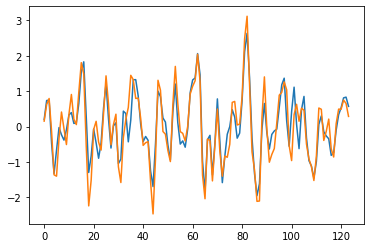

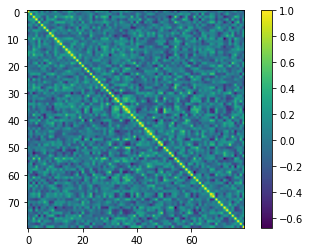

In [135]:
# Test dim reduction

import matplotlib.pyplot as plt

recon, lat = ae(test_rest_ts_torch[0])

plt.plot(recon[:,0].detach().numpy())
plt.plot(test_rest_ts_torch[0][:,0])
plt.show()

p = np.corrcoef(lat.detach().numpy().T)
plt.imshow(p)
plt.colorbar()
plt.show()

In [136]:
# Calculate latent pearson matrices

train_p = []
for sub in train_rest_ts_torch:
    recon, lat = ae(sub)
    train_p.append(np.corrcoef(lat.detach().numpy().T))
    
test_p = []
for sub in test_rest_ts_torch:
    recon, lat = ae(sub)
    test_p.append(np.corrcoef(lat.detach().numpy().T))
    
print(train_p[0].shape)
print('Complete')

(80, 80)
Complete


In [147]:
# Calculare pearson matrices

train_p = [np.corrcoef(sub) for sub in train_rest_ts]
test_p = [np.corrcoef(sub) for sub in test_rest_ts]

print(train_p[0].shape)
print('Complete')

(264, 264)
Complete


In [190]:
# Create feature vectors (right now just ages, maleness, and femaless)

X_train = []
for subj in train:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_train.append(feat)
    
X_test = []
for subj in test:
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_test.append(feat)
    
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

print(X_train[10:20])
print('Complete')

[[193   1   0]
 [217   1   0]
 [233   1   0]
 [176   1   0]
 [116   0   1]
 [246   0   1]
 [164   1   0]
 [167   0   1]
 [202   0   1]
 [108   0   1]]
Complete


In [191]:
# Convert to pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

train_p_torch = [torch.from_numpy(p).float() for p in train_p]
test_p_torch = [torch.from_numpy(p).float() for p in test_p]

X_train_torch = torch.from_numpy(X_train).float()

print('Complete')

Complete


In [223]:
# The model

import random

Nmask = 1
Nroi = train_p_torch[0].shape[0]
Nsub = X_train_torch.shape[0]
Nfeat = 1#X_train_torch.shape[1]
Nhid = 10
Nlayer = 5

class SysGcn(nn.Module):
    def __init__(self):
        super(SysGcn, self).__init__()
        self.masks = nn.Parameter(torch.randn(Nroi,Nmask))
        self.fc1 = nn.Linear(Nlayer*Nmask*Nfeat,1)
#         self.fc2 = nn.Linear(Nhid,1)
        
    # self.feat and self.ps set outside training loop   
    def forward(self, x):
        # Training or test
        trainNotTest = x[0]   
        
        m = torch.sigmoid(self.masks)
        
        # Edges can be calculated here if training
        if trainNotTest:
#             mp = torch.einsum('aij,im,jm->aijm',self.ps,m,m)
#             edges = torch.einsum('aijm,bijm->abm',mp,mp)
            edges = torch.einsum('aij,bij->ab',self.ps,self.ps)
            D1 = torch.sum(edges,dim=1)**0.5
            D1r = D1.unsqueeze(0).unsqueeze(2).expand(Nsub,Nsub,Nmask)
            D1c = D1.unsqueeze(1).unsqueeze(2).expand(Nsub,Nsub,Nmask)
            edges = edges.unsqueeze(2)
            edges = edges/D1r/D1c
            
        # Batch
        y = torch.zeros(len(x[1]))
        
        for i in range(len(x[1])):
            subj = x[1][i]
            sav = None
            idx = None
            pSav = None
            
            if trainNotTest: 
                idx = subj
                sav = self.feat[idx,:].clone()
                self.feat[idx,0] = 0
            else: 
                idx = random.randint(0,Nsub-1)
                sav = self.feat[idx,:].clone()
                pSav = self.ps[idx,:,:].clone()
                self.feat[idx,0] = 0
                self.feat[idx,1] = subj[0]
                self.feat[idx,2] = subj[1]
                self.ps[idx,:,:] = subj[2]
                
                # Edges must be recalculated for each subj on test set
                mp = torch.einsum('aij,im,jm->aijm',self.ps,m,m)
                edges = torch.einsum('aijm,bijm->abm',mp,mp)
                D1 = torch.sum(edges,dim=1)**0.5
                D1r = D1.unsqueeze(0).unsqueeze(2).expand(Nsub,Nsub,Nmask)
                D1c = D1.unsqueeze(1).unsqueeze(2).expand(Nsub,Nsub,Nmask)
                edges = edges/D1r/D1c
                
            # Features
            feat = self.feat.clone()[:,0:1]
            
            # Layer 1
            a = torch.einsum('abm,bf->afm',edges,feat)
            
            # Layer 2-5
            b = torch.einsum('abm,afn->afm',edges,a)
            c = torch.einsum('abm,afn->afm',edges,b)
            d = torch.einsum('abm,afn->afm',edges,c)
            e = torch.einsum('abm,afn->afm',edges,d)
            
            res = [a[idx],b[idx],c[idx],d[idx],e[idx]]
            h = torch.cat(res).reshape(-1)
            
            # Get age prediction
            h = self.fc1(h)
            
            y[i] = h
            
            # Restore state
            if trainNotTest:
                self.feat[idx,:] = sav
            else:
                self.feat[idx,:] = sav
                self.ps[idx,:,:] = pSav
        
        return y, m
    
sysgcn = SysGcn()
optim = torch.optim.Adam(sysgcn.parameters(), lr=1e-3)

print('Complete')

Complete


In [274]:
# Simple

Nsub = X_train_torch.shape[0]+1

ps = torch.stack([torch.ones(264,264)] + train_p_torch, dim=0)
feat = torch.cat((torch.zeros(1,3), X_train_torch))
# ps = torch.stack(train_p_torch)
# feat = X_train_torch

edges = torch.einsum('aij,bij->ab',ps,ps)
D1 = torch.sum(edges,dim=1)**0.5
D1r = D1.unsqueeze(0).unsqueeze(2).expand(Nsub,Nsub,Nmask)
D1c = D1.unsqueeze(1).unsqueeze(2).expand(Nsub,Nsub,Nmask)
edges = edges.unsqueeze(2)
edges = edges/D1r/D1c

# Layer 1
a = torch.einsum('abm,bf->afm',edges,feat)

# Layer 2-5
b = torch.einsum('abm,afn->afm',edges,a)
c = torch.einsum('abm,afn->afm',edges,b)
d = torch.einsum('abm,afn->afm',edges,c)
e = torch.einsum('abm,afn->afm',edges,d)

res = [a,b,c,d,e]
h = torch.cat(res,dim=1).reshape(Nsub,-1)

print(h.shape)

torch.Size([467, 15])


In [275]:
h = h.detach().numpy()

w, r, _, _ = np.linalg.lstsq(h[1:,:].T@h[1:,:] + 0.001*np.eye(h.shape[1]), h[1:,:].T@X_train[:,0], rcond=None)

print(r)
print('Complete')

[]
Complete


In [276]:
print(w)

[ 1.49862593e+01 -1.63654685e+03 -2.54760065e+03  1.36644505e+01
 -1.76815403e+03 -2.71299579e+03  2.70727673e-01 -1.30286428e+03
 -2.24164108e+03  2.11125373e+01 -1.92321719e+03 -1.88854671e+03
  7.61418410e+00 -2.19377369e+03 -1.67392437e+03]


In [65]:
def getGradNorm(params):
    total_norm = 0
    for p in params:
        param_norm = p.grad.data.norm(2)
        total_norm += param_norm.item() ** 2
    return total_norm ** 0.5

In [224]:
# Train Gcn

import random

Nbatch = 20
N = len(train_p_torch)
running = 0
runningL1 = 0
runningL2 = 0
nEpoch = 2000
pPeriod = 20

# Want both discreteness and contrastivity
def maskLoss(masks):
    disc = torch.sum(torch.abs(masks))
    cont = 0
    for i in range(masks.shape[1]):
        for j in range(i, masks.shape[1]):
            cont += torch.sum(torch.abs(masks[:,i]*masks[:,j]))
    return disc, cont

sysgcn.ps = torch.stack(train_p_torch, dim=0)
sysgcn.feat = X_train_torch

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(Nbatch)
    for i in range(Nbatch):
        idx = random.randint(0,N-1)
        batch.append(idx)
        truth[i] = X_train_torch[idx, 0]
    optim.zero_grad()
    pred, masks = sysgcn([True, batch])   
#     print(truth)
#     print(pred)
    l0 = torch.sum((truth-pred)**2)
#     print(l0)
    l1, l2 = maskLoss(masks)
    running += l0.detach()
    runningL1 += l1.detach()
    runningL2 += l2.detach()
    loss = l0 + l1 + l2
    loss.backward()
#     norm = getGradNorm(sysgcn.parameters())
#     print('Norm: {:f}'.format(norm))
    optim.step()
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            if epoch % pPeriod != 0:
                running /= epoch % pPeriod
                runningL1 /= epoch % pPeriod
                runningL2 /= epoch % pPeriod
            else:
                running /= pPeriod
                runningL1 /= pPeriod
                runningL2 /= pPeriod
        print('epoch {:d} loss={:f} maskDisc={:f} maskContr={:f}'.format(epoch, running, runningL1, runningL2))
        running = 0
        runningL1 = 0
        runningL2 = 0

print('Finished training')

epoch 0 loss=1214789.750000 maskDisc=136.832443 maskContr=82.996109
epoch 20 loss=1035203.812500 maskDisc=136.267120 maskContr=82.415550
epoch 40 loss=897814.875000 maskDisc=135.190628 maskContr=81.313782
epoch 60 loss=754671.375000 maskDisc=134.115311 maskContr=80.218140
epoch 80 loss=622576.750000 maskDisc=133.041595 maskContr=79.128853
epoch 100 loss=501334.312500 maskDisc=131.969711 maskContr=78.046005
epoch 120 loss=393766.812500 maskDisc=130.899780 maskContr=76.969772
epoch 140 loss=360431.750000 maskDisc=129.831940 maskContr=75.900208
epoch 160 loss=286010.562500 maskDisc=128.766235 maskContr=74.837448
epoch 180 loss=238731.421875 maskDisc=127.702866 maskContr=73.781563
epoch 200 loss=212723.468750 maskDisc=126.641884 maskContr=72.732689
epoch 220 loss=172601.828125 maskDisc=125.583412 maskContr=71.690918
epoch 240 loss=151071.343750 maskDisc=124.527573 maskContr=70.656364
epoch 260 loss=131243.375000 maskDisc=123.474472 maskContr=69.629112
epoch 280 loss=122004.773438 maskDisc=

In [216]:
print(sysgcn.masks[0:10,:])

tensor([[-0.0154],
        [-1.1909],
        [-1.3183],
        [-0.9819],
        [ 0.4967],
        [-1.9710],
        [-2.0240],
        [-0.8174],
        [-1.6005],
        [-3.1682]], grad_fn=<SliceBackward>)


[[1.         0.59425417]
 [0.59425417 1.        ]]
2.708685299986817
2.2244509868421294


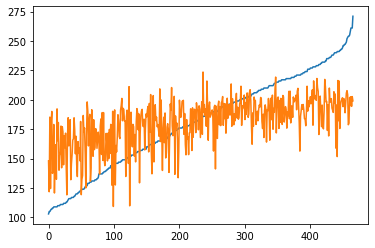

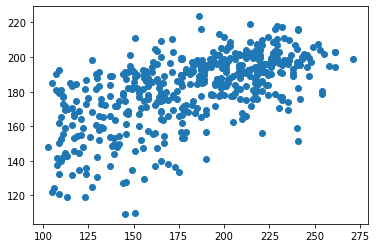

In [278]:
import matplotlib.pyplot as plt
import math

y = X_train[:,0]

# bs = 60
# ns = X_train.shape[0]
# nb = math.ceil(ns/bs)

# yPred = np.zeros(y.shape)

# for i in range(nb):
#     end = (i+1)*bs
#     if end > ns:
#         end = ns
#     batch = [True, torch.arange(i*bs,end)]
#     print(batch[1])
#     pred, masks = sysgcn(batch)
#     yPred[i*bs:end] = pred.detach().numpy()

yPred = h[1:]@w

idcs = np.argsort(y)
yPred = yPred[idcs]
y = y[idcs]

corr = np.corrcoef(y, yPred)
rmse = (np.sum((y-yPred)**2)/len(y))**0.5/12
mae = np.sum(np.abs(y-yPred))/12/len(y)

print(corr)
print(rmse)
print(mae)

plt.plot(y, label='Truth')
plt.plot(yPred, label='Prediction')
plt.show()

plt.scatter(y, yPred)
plt.show()